# Notebook Imports

In [184]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# Constants

In [176]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = 'SpamData/03_Testing/prob-nonspam.txt'
TOKEN_ALL_PROB_FILE = 'SpamData/03_Testing/prob-all-tokens.txt'

TEST_FEATURE_MATRIX = 'SpamData/03_Testing/test-features.txt'
TEST_TARGET_FILE = 'SpamData/03_Testing/test-target.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'

# Reading Files

In [8]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [55]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print (email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Function
### Email body extraction

In [10]:
def email_body_gen(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()
            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [11]:
def df_from_dir(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_gen(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_dir(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_dir(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
ham_emails = df_from_dir(EASY_NONSPAM_1_PATH, 0)
ham_emails = ham_emails.append(df_from_dir(EASY_NONSPAM_2_PATH, 0))
ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [15]:
ham_emails.shape

(3902, 2)

In [16]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of df: ', data.shape)
data.head()

Shape of df:  (5800, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [17]:
data.tail()

,CATEGORY,MESSAGE
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."
cmds,0,


# DATA Cleaning
### Missing Values

In [18]:
data['MESSAGE'].isna().values.any()

False

In [19]:
# Checking for empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [20]:
(data.MESSAGE.str.len() == 0).sum()

4

### Locating empty emails

In [21]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [22]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

In [23]:
data.drop(['cmds'], inplace=True)

In [24]:
data.shape

(5796, 2)

## Add document IDs to track emails in dataset

In [25]:
doc_ids = range(0, len(data.index))
data['DOC_ID'] = doc_ids
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [26]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head

<bound method NDFrame.head of         CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
2              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
3              1  ##############################################...   
4              1  I thought you might like these:\n\n1) Slim Dow...   
...          ...                                                ...   
5791           0  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
5792           0  > >-- be careful when using this one.) Also, t...   
5793           0  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
5794           0  So then, "Mark Hammond" <mhammond@skippinet.co...   
5795           0  Hi there,\n\n\n\nNow this is probably of no us...   

                                     FILE_NAME

In [27]:
data.tail

<bound method NDFrame.tail of         CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
2              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
3              1  ##############################################...   
4              1  I thought you might like these:\n\n1) Slim Dow...   
...          ...                                                ...   
5791           0  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
5792           0  > >-- be careful when using this one.) Also, t...   
5793           0  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
5794           0  So then, "Mark Hammond" <mhammond@skippinet.co...   
5795           0  Hi there,\n\n\n\nNow this is probably of no us...   

                                     FILE_NAME

#### Saving DataFrame 

In [28]:
data.to_json(DATA_JSON_FILE)

### Visualization

In [29]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [30]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

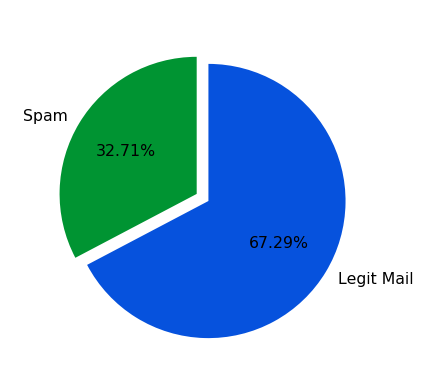

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#009432', '#0652DD']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 5}, startangle=90,
        autopct='%1.2f%%', colors=custom_colors, explode=[0, 0.1])

plt.show()

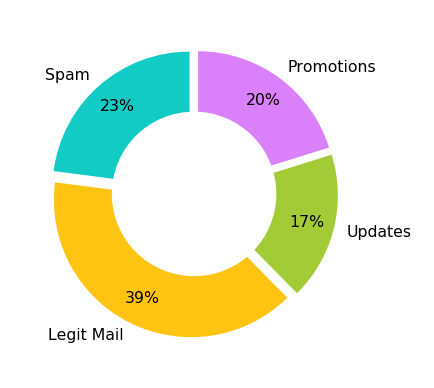

In [32]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#12CBC4', '#FFC312', '#A3CB38', '#D980FA']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 5}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Natural Language Processing

### Text Preprocessing

1. Converting everything to lower case
2. Tokenising
3. Removing stop words
4. Stripping out HTML Tags
5. Word Stemming
6. Remove punctuation

#### Downloading NLTK resources

### Tokenising

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ddmas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Removing stop words

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ddmas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\ddmas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\ddmas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

### Functions for email processing

In [35]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):
    # Converts to lowercase and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    
    return filtered_words

In [36]:
def clean_msg_no_email(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    clean_text = soup.get_text()
    
    
    # Converts to lowercase and splits up the words
    words = word_tokenize(clean_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words

In [56]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

### Slicing DataFrames and Series & Creating Subsets

In [38]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)
nested_list

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [39]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

321

In [40]:
%%time

# Using apply on full dataFrame
nested_list = data.MESSAGE.apply(clean_msg_no_email)

E:\python\Data_Science\tut_1\env\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 1min 26s


In [41]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [42]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [43]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [44]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]


In [45]:
nested_list_spam.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [46]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

spam_words.shape[0] # total number of unique words in spam messages

13242

In [47]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [48]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
ham_words = pd.Series(flat_list_ham).value_counts()

ham_words.shape[0] # total number of unique words in spam messages

20815

### Word Cloud

<function matplotlib.pyplot.show(*args, **kw)>

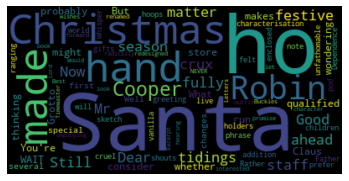

In [58]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

In [60]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [61]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [63]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

<function matplotlib.pyplot.show(*args, **kw)>

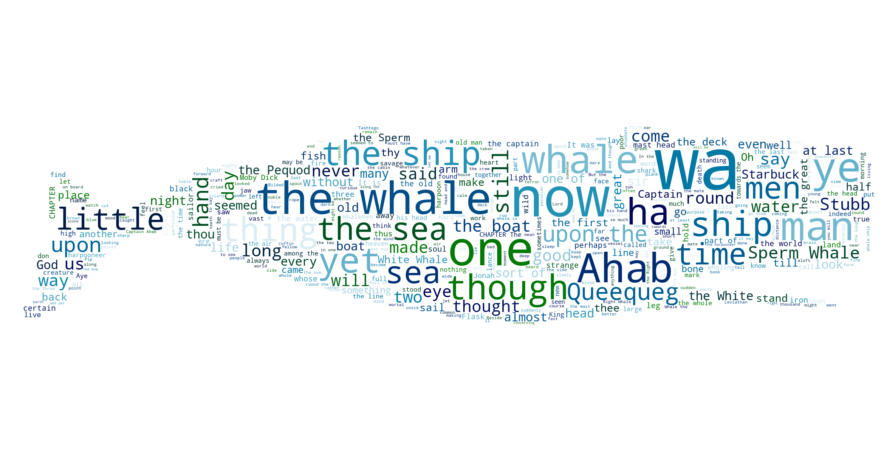

In [69]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts image array into an array
word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean').generate(novel_as_string)
plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

## Generate vocubalary and Dictionary

In [70]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_email)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

E:\python\Data_Science\tut_1\env\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [71]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('No of unique words', unique_words.shape[0])
unique_words.head( )

No of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [76]:
frequent_words = unique_words[0:2500]
print('Most Unique Words:\n',frequent_words[:10])

Most Unique Words:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


### Create Vocabulary DataFrame with a WORD_ID

In [81]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


#### Saving vocab in csv

In [83]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Generating Features and Sparse Matrix

Creating a DataFrame with one word per column

In [90]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [91]:
word_columns_df.shape

(5796, 7671)

### Splitting data into Trainning and testing dataset

In [93]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42)


In [94]:
print('No of trainning samples: ', X_train.shape[0])
print('Fraction of training set: ', X_train.shape[0] / word_columns_df.shape[0])

No of trainning samples:  4057
Fraction of training set:  0.6999654934437544


In [99]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [100]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Creating a parse matrix for training data

In [101]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [103]:
word_index.get_loc('thu')

394

In [104]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURANCE': 1, 'WORD_ID': word_id}
    
                dict_list.append(item)
        
    return pd.DataFrame(dict_list)

In [105]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 7min 37s


In [109]:
sparse_train_df.shape

(429239, 4)

In [110]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURANCE,WORD_ID
429234,1,860,1,47
429235,1,860,1,1432
429236,1,860,1,26
429237,1,860,1,21
429238,1,860,1,126


#### Combining occurences

In [111]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURANCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [113]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [114]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURANCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [116]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURANCE
258358,5795,2023,0,2
258359,5795,2036,0,1
258360,5795,2269,0,1
258361,5795,2333,0,1
258362,5795,2356,0,1


In [117]:
vocab.at[2023, 'VOCAB_WORD']

'swap'

In [118]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [120]:
train_grouped.shape

(258363, 4)

### Saving as txt file

In [122]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

#### Test data

In [123]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 5min 43s


In [125]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURANCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [126]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

### Loading features from txt into numpy array

In [127]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=' ', dtype=int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter=' ', dtype=int)

In [128]:
sparse_train_data[-5:]

array([[5795, 2023,    0,    2],
       [5795, 2036,    0,    1],
       [5795, 2269,    0,    1],
       [5795, 2333,    0,    1],
       [5795, 2356,    0,    1]])

In [130]:
print('No of rows in trainning file', sparse_train_data.shape[0])
print('No of rows in test file', sparse_test_data.shape[0])

No of rows in trainning file 258363
No of rows in test file 117776


In [131]:
print('No of emails in trainning file', np.unique(sparse_train_data[:, 0]).size)

No of emails in trainning file 4013


In [132]:
print('No of emails in test file', np.unique(sparse_test_data[:, 0]).size)

No of emails in test file 1724


### Create full matrix from sparse matrix

In [144]:
def make_full_matrix(sparse_matrix, no_words, doc_idx=0, word_idx=1, cat_idx=2, freq_idx=3):
    """
    Form a full matrix from a sparse matrix. Returns a pandas DataFrame.
    Keyword args:
    sparse_matric: numpy array
    no_words: size of the vocabulary. Total number of tokens. 
    doc_idx: position of the document id in the sparse matrix. Default: 1st column
    word_idx: position of the word id in the sparse matrix. Default: 2nd column
    cat_idx: position of the label (spam is 1, nonspam is 0). Default: 3rd column
    freq_idx: position of occurrence of word in sparse matrix. Default: 4th column
    """
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:, 0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_no = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurance = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_no, "DOC_ID"] = doc_no
        full_matrix.at[doc_no, 'CATEGORY'] = label
        full_matrix.at[doc_no, word_id] = occurance
    
    full_matrix.set_index('DOC_ID', inplace=True)
    return full_matrix

In [145]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

Wall time: 25.7 s


In [146]:
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,6,0,0,2,4,0,3,14,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Trainning Naive Bayes Model

### Calculating the probability of spam

In [147]:
prob_sum = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print('Probabilty of spam is: ', prob_sum)

Probabilty of spam is:  0.310989284824321


### Total no of tokens/Words

In [149]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4013,)

In [151]:
email_lengths[:5]

DOC_ID
0     87
1     53
2     40
3    183
4     43
dtype: int64

In [153]:
total_wc = email_lengths.sum()
total_wc

429239

### Total number of tokens in spam and ham emails

In [155]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_lengths.shape

(1248,)

In [156]:
spam_wc = spam_lengths.sum()
spam_wc

176339

In [157]:
ham_lengths = email_lengths[full_train_data.CATEGORY == 0]
ham_lengths.shape

(2765,)

In [158]:
ham_wc = ham_lengths.sum()
ham_wc

252900

In [159]:
total_wc - ham_wc - spam_wc

0

### Summing the tokens occurance in spam

In [161]:
full_train_features.shape

(4013, 2500)

In [162]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
train_spam_tokens.shape

(1248, 2500)

In [164]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) + 1
summed_spam_tokens.shape

(2500,)

In [167]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
train_ham_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1896,1,2,1,0,1,1,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1898,2,1,0,1,1,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1899,2,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1900,3,4,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1901,2,2,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
train_ham_tokens.shape

(2765, 2500)

In [169]:
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1
summed_ham_tokens.shape

(2500,)

### Calculate token probability

#### P(Token|Spam)

In [170]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_tokens_spam[:5]

0    0.012184
1    0.005228
2    0.006805
3    0.011306
4    0.006816
dtype: float64

In [171]:
prob_tokens_spam.sum()

0.9999999999999999

#### P(Token|Ham)

In [172]:
prob_tokens_ham = summed_ham_tokens / (ham_wc + VOCAB_SIZE)
prob_tokens_ham.sum()

1.0

#### P(Token)

In [173]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc
prob_tokens_all.sum()

0.9999999999999999

### Saving

In [175]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE, prob_tokens_ham)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

## Pre-processing  test data 

In [178]:
%%time
full_test_data = make_full_matrix(sparse_test_data, no_words=VOCAB_SIZE)

Wall time: 17.7 s


In [179]:
X_test = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

In [180]:
np.savetxt(TEST_TARGET_FILE, y_test)
np.savetxt(TEST_FEATURE_MATRIX, X_test)

In [182]:
# Features
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ')
# Target
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=' ')
# Token Probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter=' ')
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter=' ')

In [183]:
X_test[:5]

array([[0., 0., 1., ..., 0., 0., 0.],
       [6., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Joint Probability

### Setting Prior

$$P(Spam \, | \, X) = \frac{P(X \, | \, Spam) \, P(Spam)} {P(X)}$$

In [185]:
PROB_SPAM = 0.31098

In [186]:
np.log(prob_token_spam)

array([ -4.4076199 ,  -5.25369471,  -4.99009715, ...,  -9.52929188,
       -11.40109406, -10.0147997 ])

In [187]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [188]:
joint_log_spam[:5]

array([24.27574493,  2.15975845, 20.58942951, 17.74984588, 20.50703904])

$$P(Ham \, | \, X) = \frac{P(X \, | \, Ham) \, (1-P(Spam))} {P(X)}$$

In [189]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1-PROB_SPAM)

In [191]:
joint_log_ham[:5]

array([-60.96824668, -11.00961761, -37.96724464, -59.13228531,
       -53.78886189])

### Making Predictions

Checking for the higher joint probability

$$P(Spam \, | \, X) \, > \, P(Ham \, | \, X)$$
<center> __OR__ </center>
<br>
$$P(Spam \, | \, X) \, < \, P(Ham \, | \, X)$$

In [192]:
prediction = joint_log_spam > joint_log_ham

In [196]:
prediction[-15:]*1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [197]:
y_test[-15:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Simplification

$$P(X \, | \, Spam) \, P(Spam) ≠  \frac{P(X \, | \, Spam) \, P(Spam)}{P(X)}$$

In [198]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1-PROB_SPAM)

## Evaluation

### Accuracy

In [199]:
correct_docs = (y_test == prediction).sum()
print('Docs classified correctly', correct_docs)
numdocs_wrong = X_test.shape[0] - correct_docs
print('Docs classified incorrectly', numdocs_wrong)

Docs classified correctly 1685
Docs classified incorrectly 39


In [200]:
# Accuracy
correct_docs/len(X_test)

0.9773781902552204

In [201]:
fraction_wrong = numdocs_wrong/len(X_test)
print('Fraction classified incorrectly is {:.2%}'.format(fraction_wrong))
print('Accuracy of the model is {:.2%}'.format(1-fraction_wrong))

Fraction classified incorrectly is 2.26%
Accuracy of the model is 97.74%


### True positive and False negative

In [207]:
true_pos = (y_test == 1) & (prediction == 1)
false_pos = (y_test == 0) & (prediction == 1)
false_neg = (y_test == 1) & (prediction == 0)
false_pos = (y_test == 0) & (prediction == 0)

### Recall Score

In [204]:
recall_score = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print('Recall score is {:.2%}'.format(recall_score))

Recall score is 96.60%


### Precision Score

In [205]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print('Precision score is {:.3}'.format(precision_score))

Precision score is 0.968


### F1 Score

In [206]:
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print('F Score is {:.2}'.format(f1_score))

F Score is 0.97
